In [23]:
from tes.data import Data,PacketStream,Packet,Payload,EventFlags
from tes.hdf5 import _PacketData, _import
import numpy as np
import matplotlib.pyplot as plt
from subprocess import Popen

import logging
import sys
logger = logging.getLogger('tes')
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s:%(levelname)s %(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

trace_dt=np.dtype([('f','i4'),('s','i4')])
min_dt=np.dtype([
    ('clk','i4'),('f','i4'),('s','i4'),('low','i4'),('high','i4'),
    ('flags', (np.int32, {'f0':(np.uint8,0),'f1':(np.uint8,1),'f2':(np.uint8,2), 'f3':(np.uint8,3)})),
    ('max_slope','i4')
])
max_dt=np.dtype([
    ('clk','i4'),('f','i4'),('s','i4'),
    ('flags', (np.int32, {'f0':(np.uint8,0),'f1':(np.uint8,1),'f2':(np.uint8,2), 'f3':(np.uint8,3)}))
])

xing_dt=np.dtype([('clk','i4')])

def xings(s, thresh):
    xing = np.zeros_like(s)
    i=0
    was_above = s[0] > thresh
    for i in range(1, len(s)):
        if s[i] > thresh:
            if not was_above:
                xing[i] = 1
            was_above = True
        if s[i] < thresh:
            if was_above:
                xing[i] = -1
            was_above = False
            
    return np.where(xing==1)[0], np.where(xing==-1)[0]


In [30]:
traces=Data.fromfile('traces',trace_dt,'teslib','CFD_TB',tool='vivado')
min_data=Data.fromfile('min_data',min_dt,'teslib','CFD_TB',tool='vivado')
max_data=Data.fromfile('max_data',max_dt,'teslib','CFD_TB',tool='vivado')
low_xing=Data.fromfile('low_xings',xing_dt,'teslib','CFD_TB',tool='vivado')
high_xing=Data.fromfile('high_xings',xing_dt,'teslib','CFD_TB',tool='vivado')
maxslope_xing=Data.fromfile('maxslope_xings',xing_dt,'teslib','CFD_TB',tool='vivado')
f=traces['f']
s=traces['s']
mins, maxs = xings(s,0)

In [32]:
pthresh=0
sthresh=0
cf=(pow(2,17)//5)
if maxs[0] < mins[0]:
    maxs = maxs[1:] #start with a min
for i in range(len(min_data)):
    min_i = min_data['clk'][i]
    max_i = max_data['clk'][i]
    min_f0=np.unpackbits(min_data['flags']['f0'][i])
    min_f1=np.unpackbits(min_data['flags']['f1'][i])
    max_f0=np.unpackbits(max_data['flags']['f0'][i])
    max_f1=np.unpackbits(max_data['flags']['f1'][i])
    
    if mins[i] != min_i:
        print('min:index mismatch i:{}'.format(i))
        break
    if maxs[i] != max_i:
        print('max:index mismatch i:{}'.format(i))
        break
        
    maxima = f[maxs[i]]
    minima = f[mins[i]]
    if min_data['f'][i] != minima:
        print('minima mismatch i={}'.format(i))
    if max_data['f'][i] != maxima:
        print('maxima mismatch i={}'.format(i))
    
    if minima <= pthresh: # first rise
        if min_f0[0] == 0:
            print('missing first rise at min:i={}'.format(i))
        if max_f0[0] == 0:
            print('missing first rise at max:i={}'.format(i))
        cfi = f[maxs[i]]*cf
        cf_min = 0
        
    else: # not first rise
        if min_f0[0] == 1:
            print('unexpected first rise at min:i={}'.format(i))
        if max_f0[0] == 1:
            print('unexpected first rise at max:i={}'.format(i))
        cfi = (maxima-minima)*cf
        cf_min = minima
        
    cfi_f,_ = np.modf(cfi)
    cfi_i = np.right_shift(cfi,17)
#     if np.abs(cfi_f) >= 0.5:
#         cfi_i= int(cfi_i)+np.sign(cfi)
    high = maxima-cfi_i
    low= cf_min+cfi_i
    
#         p=(f[maxs[i]]-f[mins[i]]
    if min_data['high'][i] != high:
        print('high mismatch',maxima,min_data['high'][i],high,cfi_i,i)
    if min_data['low'][i] != low:
        print('low mismatch',minima,min_data['low'][i],low,cfi_i,i)
    
    if low < minima:
        if min_f0[5] == 0:
            print('missing cfd_error minima={} low={} i={} '.format(minima,low,i))
    else:
        if min_f0[5] == 1:
            print('unexpected cfd_error minima={} low={} i={} '.format(minima,low,i))
            
    m_slope = max(s[mins[i]:maxs[i]])
    if m_slope != min_data['max_slope'][i]:
        print('max_slope mismatch',m_slope,min_data['max_slope'][i],i)
    
            
print(len(min_data))

unexpected cfd_error minima=36 low=42 i=2 
unexpected cfd_error minima=46 low=47 i=3 
unexpected cfd_error minima=-110 low=-17 i=4 
unexpected cfd_error minima=-215 low=-1 i=17 
unexpected cfd_error minima=14 low=15 i=24 
unexpected cfd_error minima=-50 low=-1 i=26 
unexpected cfd_error minima=-278 low=-16 i=28 
unexpected cfd_error minima=-91 low=-10 i=30 
unexpected cfd_error minima=-49 low=-9 i=41 
unexpected cfd_error minima=16 low=16 i=45 
unexpected cfd_error minima=-270 low=-9 i=47 
unexpected cfd_error minima=-203 low=-17 i=48 
unexpected cfd_error minima=-121 low=-9 i=57 
unexpected cfd_error minima=120 low=144 i=62 
unexpected cfd_error minima=-103 low=-12 i=63 
unexpected cfd_error minima=51 low=94 i=65 
unexpected cfd_error minima=-134 low=-10 i=66 
unexpected cfd_error minima=100 low=102 i=69 
unexpected cfd_error minima=-162 low=-13 i=70 
unexpected cfd_error minima=-162 low=-8 i=75 
unexpected cfd_error minima=-77 low=-3 i=84 
unexpected cfd_error minima=46 low=49 i=89 


In [15]:
j=0
min_data['low'][j]<f[mins[j]]

False

In [239]:
min_data['flags'].view(np.dtype(['u1','u1','u1','u1']))

TypeError: data type not understood

In [111]:
np.unpackbits(min_data['flags'][i].astype('u1'))

array([1, 0, 1, 0, 1, 1, 0, 0], dtype=uint8)

In [86]:
min_data['f'][i],f[mins[i]:mins[i]+10]

(0, array([0, 0, 0, 1, 2, 3, 4, 5, 6, 8]))

In [102]:
min_data['s'][i]

3

In [114]:
min_data['clk'][i],mins[i]

(1171, 1172)

<IPython.core.display.Javascript object>


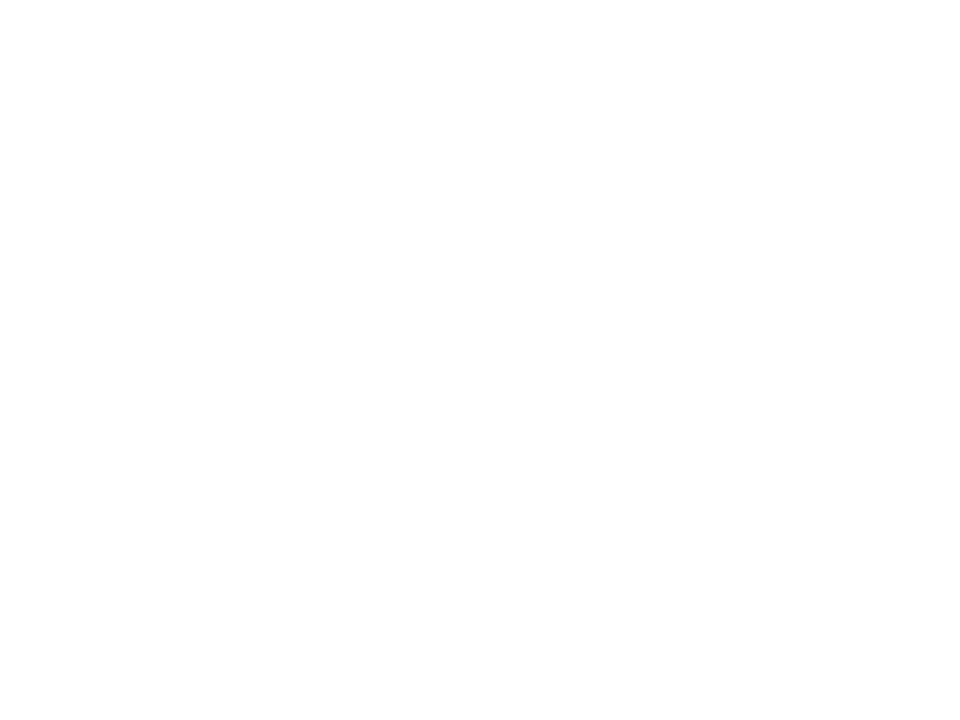

In [115]:
%matplotlib notebook
for k in range(1, 1000):
#     plt.plot([0,l],[0,0],':k')
#     plt.plot(s[mins[k]:maxs[k]+1],'r')
    plt.plot(f[mins[k]:maxs[k]+1],'b')